# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import time
import pickle
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from itertools import zip_longest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam, LBFGS

from simdata import  fdd, pdeinp, icinp, bcinp,HT_sim ,scaler, invscaler
from loss_func import loss_fn_data,pde_loss,ic_loss,boundary_loss
from train_testloop import training_loop




Using device: cuda
Using device: cuda
Using device: cuda


## Simulation Data Generation for 1D Heat Transfer

3.507078228077629e-05 3.394878564540885e-05 3.686205086349929e-05
The spatial step is 0.0003061224489795918
The time step is 0.0012711033647622566


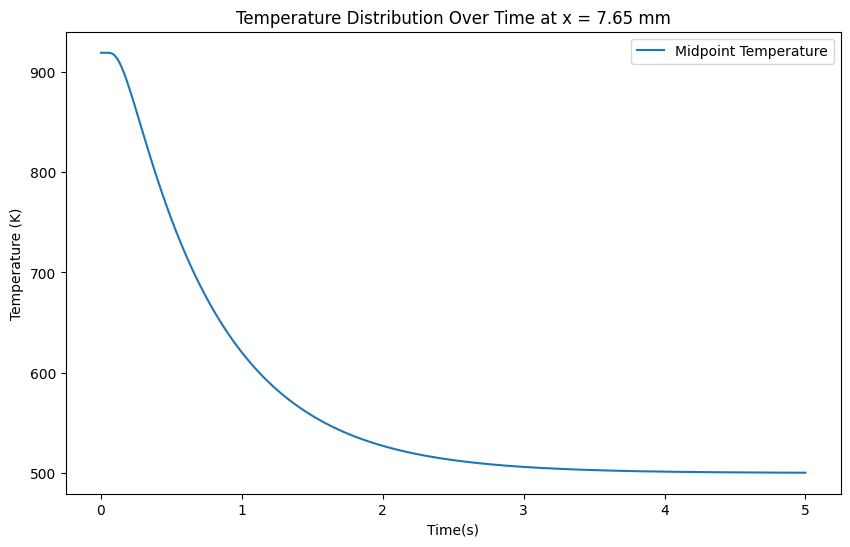

In [2]:
# The simulation data is generated using the datagen function in simdata.py
# the data solves 1D heat equation with dirichlet boundary conditions



length = 15e-3
time_end = 5.0
numpoints = 50
temp_init = 919.0
t_surr = 500.0

heat_data = HT_sim(length, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
tempfield = heat_data.datagen()

heat_data.plot_temp(25)
dt = heat_data.dt
dx = heat_data.dx






## Data Preparation for PINN training

In [3]:
# Temperature dataset
temp_data = tempfield.flatten()

def temp_scaler(temp_data, temp_init, t_surr):
    temp_data = (temp_data - t_surr) / (temp_init - t_surr)
    return temp_data

# temp_data = scaler(temp_data,400.0,919.0)

temp_data_s = temp_scaler(temp_data, temp_init, t_surr)




### Input Data preparation

In [4]:

# input dataset- fdd
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1]

pde_pts= 20000
ic_pts = 1000
bc_pts = 1000

x_c = 1/length
t_c = (alpha/(length**2))
temp_c = 919.0

inp_data = fdd(15e-3, time_end, numpoints, num_steps)



def scale2(x,x_c,t_c):
    x1 = x.copy()
    x1[:,0] = x[:,0] * x_c
    x1[:,1] = x[:,1] * t_c
    return x1

inp_data2 = scale2(inp_data,x_c,t_c)



# input dataset-pde residual
# The pde inputs are generated using the pdeinp function in simdata.py
xmin = 0+dx
xmax = length-dx
pde_data = pdeinp(xmin,xmax,0.01,time_end,pde_pts,"Sobol") 

pde_data2 = scale2(pde_data,x_c,t_c)

# input dataset - ic residual
ic_data = icinp(15e-3,ic_pts,scl="False")
ic_data2 = scale2(ic_data,x_c,t_c)
# input dataset - boundary residual
bc_ldata = bcinp(15e-3,time_end,bc_pts,dt,scl="False")[0]
bc_rdata = bcinp(15e-3,time_end,bc_pts,dt,scl="False")[1]

print(bc_ldata[:,1].max())

bc_ldata2 = scale2(bc_ldata,x_c,t_c)
bc_rdata2 = scale2(bc_rdata,x_c,t_c)


d:\Softwares\anaconda3\envs\pinn\Lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+20002=20002. 
  warnings.warn(


The number of points in the PDE input is 20000
The number of points in the initial condition is 1000
scaling not initiated
The number of points in the left boundary condition is 1000
The number of points in the right boundary condition is 1000
scaling not initiated
The number of points in the left boundary condition is 1000
The number of points in the right boundary condition is 1000
scaling not initiated
5.0


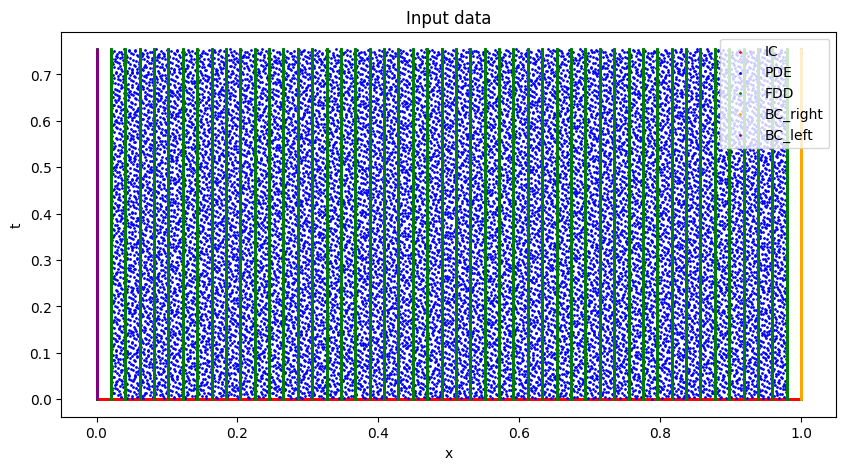

In [5]:
plt.figure(figsize=(10, 5))
plt.plot()
plt.scatter(ic_data2[:,0],ic_data2[:,1],s=1,label="IC",color="red")
plt.scatter(pde_data2[:,0],pde_data2[:,1],s=1,label="PDE",color="blue")
plt.scatter(inp_data2[:,0],inp_data2[:,1],s=1,label="FDD",color="green")
plt.scatter(bc_rdata2[:,0],bc_rdata2[:,1],s=1,label="BC_right",color="orange")
plt.scatter(bc_ldata2[:,0],bc_ldata2[:,1],s=1,label="BC_left",color="purple")
plt.title("Input data")
plt.xlabel("x")
plt.ylabel("t")
plt.legend(loc='upper right')

plt.show()


### GPU prep

In [6]:
# check for gpu
if torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

print('Using device:', device)

Using device: cuda
Using device: cuda


### Tensor inputs

In [7]:
input_t = torch.tensor(inp_data2).float().to(device)
inp_pdet = torch.tensor(pde_data2).float().to(device)
inp_ict = torch.tensor(ic_data).float().to(device)
inp_bclt = torch.tensor(bc_ldata2).float().to(device)
inp_bclr = torch.tensor(bc_rdata2).float().to(device)

print(input_t.shape)

temp_t = torch.tensor(temp_data_s).float().to(device)
temp_t = temp_t.view(-1,1)


# temp_init = scaler(temp_init,500.0,919.0)
temp_init = 1.0
t_surr = 0.0
temp_init_t = 1.0
T_L = (574.4 +273.0)                   #  K -Liquidus Temperature (615 c) AL 380
T_L_s = scaler(T_L,temp_init, t_surr)                     #  K -Liquidus Temperature (615 c) AL 380
# T_L = scaler(T_L,500.0,919.0)
T_S = (497.3 +273.0)                   #  K -Solidus Temperature (615 c) AL 380
T_S_s = scaler(T_S,temp_init, t_surr)                     #  K -Solidus Temperature (615 c) AL 380
# T_S = scaler(T_S,500.0,919.0)                     #  K -Solidus Temperature (615 c) AL 380
t_surr_s = 0.0
# t_surr = scaler(t_surr,500.0,919.0)
T_lt = torch.tensor(T_L_s).float().to(device)    # Liquidus Temperature tensor
T_st = torch.tensor(T_S_s).float().to(device)    # Solidus Temperature tensor
t_surrt = torch.tensor(t_surr_s).float().to(device)   # Surrounding Temperature tensor

temp_var = {"T_st":T_st,"T_lt":T_lt,"t_surrt":t_surrt,"temp_init_t":temp_init_t}


torch.Size([196750, 2])


### Dataset Preparation for pytorch

In [8]:
train_inputs,test_inputs =train_test_split(input_t,test_size=0.2,random_state=42) # input data split

tr_inp_pde,ts_inp_pde = train_test_split( inp_pdet,test_size=0.2,random_state=42) # input pde data split
# print(tr_inp_pde.shape)
tr_inp_ic,ts_inp_ic = train_test_split( inp_ict,test_size=0.2,random_state=42) # input ic data split
print(tr_inp_ic.shape)

tr_inp_bcl,ts_inp_bcl = train_test_split( inp_bclt,test_size=0.2,random_state=42) # input bc left data split
tr_inp_bcr,ts_inp_bcr = train_test_split( inp_bclr,test_size=0.2,random_state=42) # input bc right data split
# nn
# 

train_temp,test_temp = train_test_split(temp_t,test_size=0.2,random_state=42) # output data split




torch.Size([800, 2])


In [9]:
class Data_Tensor_Dataset(TensorDataset):#dataset class for tsimulation data
    def __init__(self,inputs,outputs,transform=None, target_transform =None):   
        super().__init__(inputs,outputs) #call the parent class constructor
        self.inputs = inputs
        self.outputs = outputs
        self.transform = transform
        self.target_transform = target_transform
    def __getitem__(self, index):
        return self.inputs[index],self.outputs[index]
    
    def __len__(self):
        return len(self.inputs)

class ResDataset(TensorDataset): #dataset class for pde residuals and bcs,ics
    def __init__(self, inputs,transform=None, target_transform =None):
        self.inputs = inputs
        

    def __getitem__(self, index):
        return self.inputs[index]
    
    def __len__(self):
        return len(self.inputs)

### Dataset Preparation

In [10]:
inp_dataset = Data_Tensor_Dataset(train_inputs,train_temp)
inp_dataset_test = Data_Tensor_Dataset(test_inputs,test_temp)

inp_pde_dataset = ResDataset(tr_inp_pde) # pde residual dataset for training
inp_pde_dataset_test = ResDataset(ts_inp_pde) # pde residual dataset for testing

inp_ic_dataset = ResDataset(tr_inp_ic) # ic residual dataset for training
inp_ic_dataset_test = ResDataset(ts_inp_ic) # ic residual dataset for testing

inp_bcl_dataset = ResDataset(tr_inp_bcl) # bc left residual dataset for training
inp_bcl_dataset_test = ResDataset(ts_inp_bcl) # bc left residual dataset for testing

inp_bcr_dataset = ResDataset(tr_inp_bcr) # bc right residual dataset for training
inp_bcr_dataset_test = ResDataset(ts_inp_bcr)   # bc right residual dataset for testing

In [11]:
print(len(inp_ic_dataset))

800


### Dataloader Preparation

In [12]:
rand_smpl = RandomSampler(inp_dataset, replacement=True, num_samples=1000)  # random sampler for training/simulation data
rand_smpl_pde = RandomSampler(inp_pde_dataset, replacement=True, num_samples=1000) # random sampler for pde residuals-training
rand_smpl_ic = RandomSampler(inp_ic_dataset, replacement=True, num_samples=1000)  # random sampler for ic residuals-training
rand_smpl_bcl = RandomSampler(inp_bcl_dataset, replacement=True, num_samples=1000) # random sampler for bc left residuals-training
rand_smpl_bcr = RandomSampler(inp_bcr_dataset, replacement=True, num_samples=1000) # random sampler for bc right residuals-training

rand_smpl_test = RandomSampler(inp_dataset_test, replacement=True, num_samples=1000)  # random sampler for testing/simulation data
rand_smpl_pde_test = RandomSampler(inp_pde_dataset_test,replacement=True, num_samples=1000)  # random sampler for pde residuals
rand_smpl_ic_test = RandomSampler(inp_ic_dataset_test,replacement=True, num_samples= 1000)  # random sampler for ic residuals
rand_smpl_bcl_test = RandomSampler(inp_bcl_dataset_test,replacement=True,num_samples=1000) # random sampler for bc left residuals
rand_smpl_bcr_test = RandomSampler(inp_bcr_dataset_test,replacement=True,num_samples=1000) # random sampler for bc right residuals

train_loader = DataLoader(inp_dataset, batch_size=128, sampler=rand_smpl) # training data loader
pde_loader = DataLoader(inp_pde_dataset, batch_size=128, sampler=rand_smpl_pde) # pde residual data loader training
ic_loader = DataLoader(inp_ic_dataset, batch_size=128, sampler=rand_smpl_ic) # ic residual data loader training
bcl_loader = DataLoader(inp_bcl_dataset, batch_size=128, sampler=rand_smpl_bcl) # bc left residual data loader training
bcr_loader = DataLoader(inp_bcr_dataset, batch_size=128, sampler=rand_smpl_bcr) # bc right residual data loader training


test_loader = DataLoader(inp_dataset_test, batch_size=128, sampler=rand_smpl_test) # testing data loader
pde_loader_test = DataLoader(inp_pde_dataset_test, batch_size=128, sampler=rand_smpl_pde_test)
ic_loader_test = DataLoader(inp_ic_dataset_test, batch_size=128, sampler=rand_smpl_ic_test)
bcl_loader_test = DataLoader(inp_bcl_dataset_test, batch_size=128, sampler=rand_smpl_bcl_test)
bcr_loader_test = DataLoader(inp_bcr_dataset_test, batch_size=128, sampler=rand_smpl_bcr_test)




## NN Architecture Definition

In [13]:
from model import PINN

In [14]:
input_size = 2
hidden_size = 20
output_size=1

learning_rate = 0.005
hidden_layers = 5

epochs_1 = 10000
epochs_2 = 10

model = PINN(input_size, hidden_size, output_size,hidden_layers).to(device)
optimizer_1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_2 = torch.optim.LBFGS(model.parameters(), lr=learning_rate)


In [15]:
# print(model)

### Loss Function 

In [16]:
torch.autograd.set_detect_anomaly(True)

#train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs_1, model, loss_fn_data, \
                #   optimizer_1,train_loader,pde_loader, ic_loader,\
                #   bcl_loader,bcr_loader,\
                #   test_loader,pde_loader_test,ic_loader_test,\
                #   bcl_loader_test,bcr_loader_test,\
                #   temp_var)  # Train the model 

loss_train,loss_test,best_model = training_loop(epochs_1, model, loss_fn_data, \
                  optimizer_1,train_loader,pde_loader, ic_loader,\
                  bcl_loader,bcr_loader,\
                  test_loader,pde_loader_test,ic_loader_test,\
                  bcl_loader_test,bcr_loader_test,\
                  temp_var)

# train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs_2, model, loss_fn_data, \
#                   optimizer_2,train_loader,pde_loader, ic_loader,\
#                   bcl_loader,bcr_loader,\
#                   test_loader,pde_loader_test,ic_loader_test,\
#                   bcl_loader_test,bcr_loader_test,\
#                   temp_var) 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model



d:\Softwares\anaconda3\envs\pinn\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 
----------------------------------------------------------------------------------------------------
| Epoch 1,            | Training-Loss 5.5803e+00,| Test-Loss 3.3960e+00   |
----------------------------------------------------------------------------------------------------
| Data-loss 2.7968e-01,| pde-loss 1.3373e+00,| initc-loss 5.1458e-02,|bc_loss 3.6169e-01|
----------------------------------------------------------------------------------------------------
| Data-loss-test 4.7422e-01,| pde-loss-test 5.9074e-02,| initc-loss-test 4.8614e-02,|bc_loss-test 3.3324e-01|
----------------------------------------------------------------------------------------------------
 
 
----------------------------------------------------------------------------------------------------
| Epoch 11,            | Training-Loss 1.0748e+00,| Test-Loss 9.7999e-01   |
----------------------------------------------------------------------------------------------------
| Data-loss 6.5164e-02,| pde-loss 9

KeyboardInterrupt: 

In [ ]:
def move_to_cpu(obj):
    """Recursively move tensors in a dictionary or list to CPU."""
    if isinstance(obj, torch.Tensor):
        return obj.cpu()
    elif isinstance(obj, list):
        return [move_to_cpu(item) for item in obj]  # Convert tensors inside lists
    elif isinstance(obj, dict):
        return {k: move_to_cpu(v) for k, v in obj.items()}  # Convert tensors inside dicts
    return obj  # Return unchanged for other types

# Ensure all tensors inside lists/dicts are on CPU
loss_train = move_to_cpu(loss_train)
loss_test = move_to_cpu(loss_test)

In [ ]:

# parser = argparse.ArgumentParser()
# parser.add_argument("--job_id", type=str, default="000000")
# args = parser.parse_args()

# Create a unique folder based on SLURM job ID

folder_path = f"output_files/"
os.makedirs(folder_path, exist_ok=True)


# Define file path
loss_train_pth = os.path.join(folder_path, "train-loss.pkl")
loss_test_pth = os.path.join(folder_path, "test-loss.pkl")

torch.save(best_model.state_dict(),os.path.join(folder_path, "best-model.pth"))


# Save file in the specified folder
with open(loss_train_pth, "wb") as f:
    pickle.dump(loss_train, f)

with open(loss_test_pth, "wb") as f:
    pickle.dump(loss_test, f)


print(f"File saved at: {loss_train_pth}")
print(f"File saved at: {loss_test_pth}")

File saved at: output_files/train-loss.pkl
File saved at: output_files/test-loss.pkl
